# Commutator bounds

In this tutorial, we evaluate Trotter error commutator bounds and apply them to the Fermi-Hubbard model on a one-dimensional lattice.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fh_comm as fhc

## General commutator bounds

We assume that the Hamiltonian $H = \sum_{\gamma=1}^{\Gamma} H_\gamma$ consists of $\Gamma$ summands, and consider the Strang (second-order Suzuki) splitting method, denoted $\mathscr{S}_2(t)$. For this method, the following particular Trotter error bound holds (see [Phys. Rev. X 11, 011020 (2021)](https://doi.org/10.1103/PhysRevX.11.011020), Proposition 10):
$$
\left\lVert\mathscr{S}_2(t) - e^{-i t H}\right\rVert \le \frac{t^3}{12} \sum_{\gamma_1=1}^{\Gamma} \left\lVert \left[\sum_{\gamma_3=\gamma_1+1}^{\Gamma} H_{\gamma_3}, \left[\sum_{\gamma_2=\gamma_1+1}^{\Gamma} H_{\gamma_2}, H_{\gamma_1}\right] \right] \right\rVert + \frac{t^3}{24} \sum_{\gamma_1=1}^{\Gamma} \left\lVert \left[H_{\gamma_1}, \left[\sum_{\gamma_2=\gamma_1+1}^{\Gamma} H_{\gamma_2}, H_{\gamma_1}\right] \right] \right\rVert.
$$

In [2]:
# evaluate bound for 3 Hamiltonian terms
comm_bound_terms = fhc.commutator_bound_strang(3)
for cbt in comm_bound_terms:
    print(cbt)

1/24 * [H_0, [H_1, H_0]]
1/12 * [H_1, [H_1, H_0]]
1/12 * [H_2, [H_1, H_0]]
1/24 * [H_0, [H_2, H_0]]
1/12 * [H_1, [H_2, H_0]]
1/12 * [H_2, [H_2, H_0]]
1/24 * [H_1, [H_2, H_1]]
1/12 * [H_2, [H_2, H_1]]


In general, we can evaluate the coefficients from Theorem 1 of [arXiv:2306.10603](https://arxiv.org/abs/2306.10603) as follows, illustrated for the fourth-order Suzuki rule and two Hamiltonian terms:

In [3]:
# fourth-order Suzuki product rule with two Hamiltonian terms
rule = fhc.SplittingMethod.suzuki(2, 2)
print(rule)
# left-right partition boundary
s = (rule.num_layers + 1) // 2
print("s:", s)
comm_bound_terms = fhc.commutator_bound(rule, s)
for cbt in comm_bound_terms:
    print(cbt)

Splitting method of order 4 for 2 terms using 11 layers,
  indices: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
  coeffs:  [0.20724538589718786, 0.4144907717943757, 0.4144907717943757, 0.4144907717943757, -0.12173615769156357, -0.6579630871775028, -0.12173615769156357, 0.4144907717943757, 0.4144907717943757, 0.4144907717943757, 0.20724538589718786]
s: 6
0.004701334310169882 * [H_0, [H_0, [H_0, [H_1, H_0]]]]
0.009689668290122168 * [H_1, [H_0, [H_0, [H_1, H_0]]]]
0.00463891008158979 * [H_0, [H_1, [H_0, [H_1, H_0]]]]
0.017328153057109535 * [H_1, [H_1, [H_0, [H_1, H_0]]]]
0.005703818762629349 * [H_0, [H_0, [H_1, [H_1, H_0]]]]
0.009726162358456835 * [H_1, [H_0, [H_1, [H_1, H_0]]]]
0.00737205664595221 * [H_0, [H_1, [H_1, [H_1, H_0]]]]
0.02837343440542591 * [H_1, [H_1, [H_1, [H_1, H_0]]]]


This reproduces Eq. (M12) in [Phys. Rev. X 11, 011020 (2021)](https://doi.org/10.1103/PhysRevX.11.011020).

## Application to the Fermi-Hubbard model

For a concrete Hamiltonian, one still needs to evaluate the nested commutators and their spectral norms. Here we consider the Fermi-Hubbard model $H_{\text{FH}}$ on a one-dimensional lattice.

We decompose $H_{\text{FH}} = H_1 + H_2 + H_3$ with $H_1$ containing the "even-odd" kinetic hopping terms, $H_2$ the "odd-even" hopping terms and $H_3$ the interactions. The sublattice $\Lambda' = (2 \mathbb{Z})_{/L}$ captures the translation invariance by two sites.
\begin{align*}
H_1 &= v \sum_{i \in \Lambda'} \sum_{\sigma \in \{\uparrow, \downarrow\}} h_{i, i+1, \sigma}^{},\\
H_2 &= v \sum_{i \in \Lambda'} \sum_{\sigma \in \{\uparrow, \downarrow\}} h_{i-1, i, \sigma}^{},\\
H_3 &= u \sum_{i \in \Lambda'} \big( n_{i,\uparrow}^{} n_{i,\downarrow}^{} + n_{i+1,\uparrow}^{} n_{i+1,\downarrow}^{} \big).
\end{align*}

In [4]:
# Hamiltonian coefficients
v = -1
u =  1  # other values can be included as prefactor depending on the number of interaction terms

# construct a sub-lattice for translations
translatt = fhc.SubLattice([[2]])

# construct the Fermi-Hubbard Hamiltonian operators on a 1D lattice
h0 = fhc.SumOp([fhc.HoppingOp(( 0,), ( 1,), s, v) for s in [0, 1]])  # sum over spin
h1 = fhc.SumOp([fhc.HoppingOp((-1,), ( 0,), s, v) for s in [0, 1]])  # sum over spin
h2 = fhc.SumOp([fhc.ProductOp([fhc.NumberOp((x,), s, 1) for s in [0, 1]], u) for x in [0, 1]])
hlist = [h0, h1, h2]

Next, we compute all nested commutators up to a specified depth (here 3):

In [5]:
comm_tab = fhc.NestedCommutatorTable(hlist, 3, translatt, bias=1e-8)
tab1 = comm_tab.table(1)
# example
print("tab1[0][1]:", tab1[0][1])
tab2 = comm_tab.table(2)
# example
print("tab2[1][2][1]:", tab2[1][2][1])
print("tab2[1][2][1].norm_bound():", tab2[1][2][1].norm_bound())

tab1[0][1]: g_{(-1,), (1,), up} + (-1) g_{(0,), (2,), up} + g_{(-1,), (1,), dn} + (-1) g_{(0,), (2,), dn}
tab2[1][2][1]: (-4) (g_{(-1,), (0,), up}) @ (g_{(-1,), (0,), dn}) + (-4) (n_{(-1,), up}) @ (n_{(-1,), dn}) + (4) (n_{(-1,), up}) @ (n_{(0,), dn}) + (4) (n_{(0,), up}) @ (n_{(-1,), dn}) + (-4) (n_{(0,), up}) @ (n_{(0,), dn})
tab2[1][2][1].norm_bound(): 8.0


We can now evaluate the commutator bound for the Strang splitting method:

In [6]:
print("bound specialized for second-order Suzuki method:")
comm_bound_terms = fhc.commutator_bound_strang(len(hlist))

# sort by number of interaction terms
err_bound = 3 * [0]
for term in comm_bound_terms:
    print(term)
    # number of occurrences of interaction term in current nested commutator
    num_int = sum(1 if i == len(hlist)-1 else 0 for i in term.commidx)
    err_bound[num_int] += term.weight * tab2[term.commidx[0]][term.commidx[1]][term.commidx[2]].norm_bound()
# the entries still need to be divided by 2 to obtain the error per lattice site
print("err_bound:", err_bound)

bound specialized for second-order Suzuki method:
1/24 * [H_0, [H_1, H_0]]
1/12 * [H_1, [H_1, H_0]]
1/12 * [H_2, [H_1, H_0]]
1/24 * [H_0, [H_2, H_0]]
1/12 * [H_1, [H_2, H_0]]
1/12 * [H_2, [H_2, H_0]]
1/24 * [H_1, [H_2, H_1]]
1/12 * [H_2, [H_2, H_1]]
err_bound: [1.0, 1.3333333333333333, 0.3333333333333333]


Here, `err_bound` partitions the error coefficients into powers of the interaction term $H_3$. The analytical formula for the final bound is
$$
\left\lVert\mathscr{S}_2(t) - e^{-i t H}\right\rVert \le t^3 \frac{\mathtt{sum(err\_bound)}}{2},
$$
where the factor 1/2 is due to specifying the error per lattice site. (The sublattice $\Lambda'$ only covers half of all sites.)

Finally, we compare the commutator bound with the empirical Trotter error on a lattice with $L = 4$ sites:

In [7]:
# matrix representation of the Hamiltonian, as reference
L = 4
hlist_mat = [h.as_field_operator().as_matrix((L,), translatt).todense() for h in hlist]
Hmat = sum(hlist_mat)
print(Hmat.shape)

(256, 256)


The following utility function simulates the Trotterized time evolution based on matrix representations, as reference calculation to evaluate the empirical error.

In [8]:
def trotterized_time_evolution(hlist, method: fhc.SplittingMethod, dt: float, nsteps: int):
    """
    Compute the numeric ODE flow operator of the quantum time evolution
    based on the provided splitting method.
    """
    V = None
    for i, c in zip(method.indices, method.coeffs):
        if V is None:
            V = scipy.linalg.expm(-1j*c*dt*hlist[i])
        else:
            V = scipy.linalg.expm(-1j*c*dt*hlist[i]) @ V
    return np.linalg.matrix_power(V, nsteps)

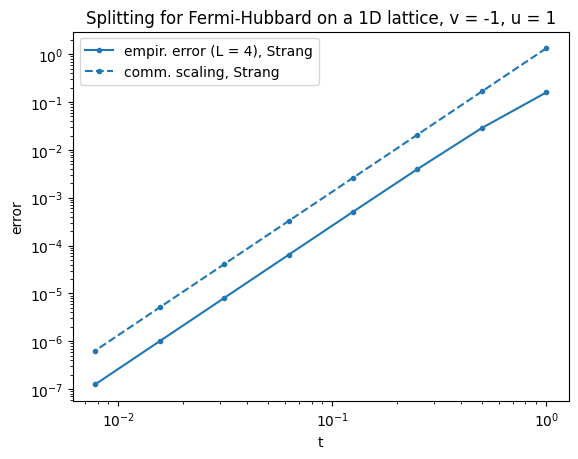

In [9]:
# Strang splitting method
method = fhc.SplittingMethod.suzuki(len(hlist), 1)

tlist = [0.5**n for n in range(8)]
err_ref = np.zeros(len(tlist))
errcomm = np.zeros(len(tlist))
for i, t in enumerate(tlist):
    # reference global unitary
    expitH = scipy.linalg.expm(-1j*Hmat*t)
    V = trotterized_time_evolution(hlist_mat, method, t, 1)
    # empirical error per lattice site
    err_ref[i] = np.linalg.norm(V - expitH, ord=2) / L
    # factor 1/2 to get the error per lattice site (terms are understood as translations by two sites)
    errcomm[i] = t**(method.order + 1) * 0.5 * sum(err_bound)
# visualize results
plt.loglog(tlist, err_ref, '.-', label=f"empir. error (L = {L}), Strang", color="C0")
plt.loglog(tlist, errcomm, '.--', label="comm. scaling, Strang", color="C0")
plt.xlabel("t")
plt.ylabel("error")
plt.title(f"Splitting for Fermi-Hubbard on a 1D lattice, v = {v}, u = {u}")
plt.legend()
plt.show()